In [15]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import wandb
from custom_datasets import dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

wandb_api.login()
api = wandb.Api()
run_name = "22pa2kbx"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {device}")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [2]:
class_name, model_script = wandb_api.get_training(run_name)
exec(model_script.read())
print(f"Model name: {class_name}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


Model name: VGG11


In [5]:
data_at = api.artifact(
    "matiasetcheverry/microstructure-reconstruction/raw_fabrics" + ":3_images"
)
data_dir = data_at.download()
fabrics_df = wandb_api.convert_table_to_dataframe(data_at.get("fabrics"))
fabrics_df = fabrics_df.sample(frac=config["frac_sample"], random_state=config["seed"])
fabrics_df["photos"] = fabrics_df["photos"].apply(
    func=lambda photo_paths: [str(repo_path / Path(x)) for x in photo_paths]
)
single_fabrics_df = dataframe_reformat.convert_into_single_entry_df(
    fabrics_df, "photos"
)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_fabrics = deepcopy(single_fabrics_df)
normalized_fabrics.iloc[:, 1:-1] = scaler.fit_transform(single_fabrics_df.iloc[:, 1:-1])
train_df, test_df = train_test_split(
    normalized_fabrics,
    train_size=config["train_val_split"],
    random_state=config["seed"],
    shuffle=True,
)

transform = transforms.Compose(
    [
        transforms.CenterCrop(207),
        transforms.Resize((config["input_width"], config["input_width"])),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3, sigma=0.5),
    ]
)

train_dataset = dataset.SinglePhotoDataset(
    train_df, normalization=False, transform=transform
)
validation_dataset = dataset.SinglePhotoDataset(
    test_df, normalization=False, transform=transform
)
print(f"Length training set: {len(train_dataset)}")
print(f"Length validation set: {len(validation_dataset)}")
train_dataloader = DataLoader(
    train_dataset, batch_size=config["batch_size"], shuffle=True, **kwargs
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=config["batch_size"], shuffle=False, **kwargs
)


Length training set: 3779
Length validation set: 1621


In [6]:
model = VGG11(input_channel=1, input_height=config["input_width"], output_size=23)
model.load_state_dict(torch.load("tmp/model_dict.pt", map_location=torch.device("cpu")))
model.eval()


VGG11(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), paddin

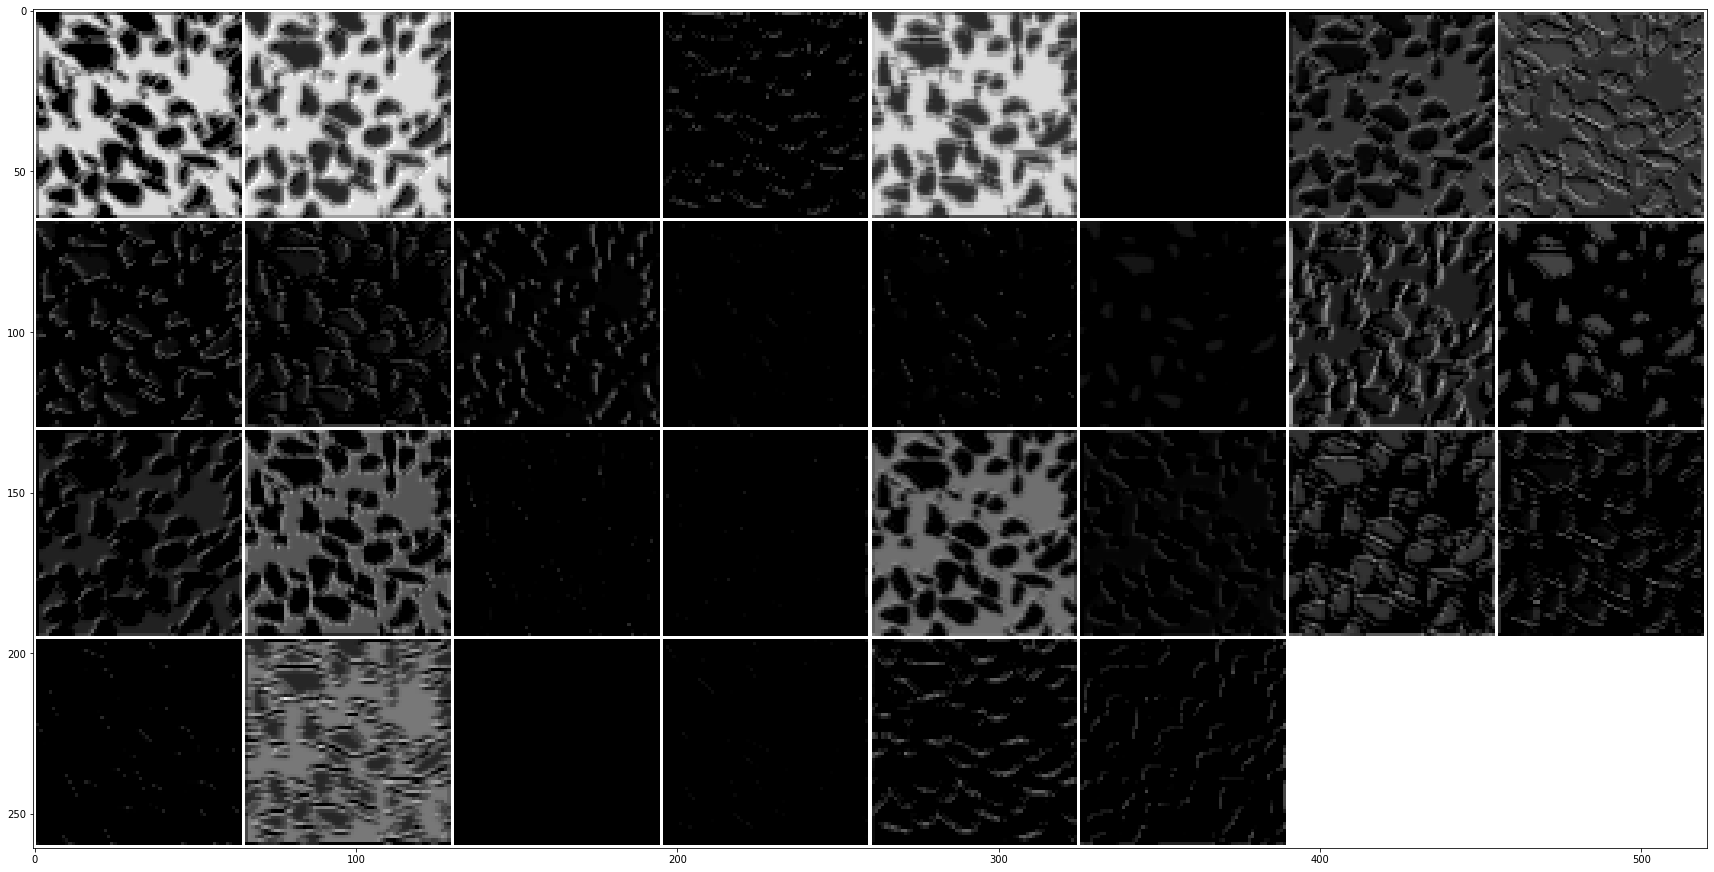

In [7]:
save_output = training.SaveOutput()
handle = model.conv_layers[1].register_forward_hook(save_output)
image = train_dataset[0][0]
model(image.unsqueeze(0))
handle.remove()
images = save_output.outputs[0].permute(1, 0, 2, 3).detach().cpu()[:30]
grid_img = utils.make_grid(images, normalize=True, pad_value=1, padding=1)
plt.figure(figsize=(30, 30))
plt.imshow(grid_img.permute(1, 2, 0))


In [8]:
predictions, targets = training.compute_predictions(
    model, device, validation_dataloader
)
errors = (
    pd.DataFrame(
        training.compute_errors(predictions, targets, device, scaler),
        columns=train_df.columns[1:-1],
    ).mean()
    * 100
)


In [10]:
print(f"Loss on normalized tensors: {nn.L1Loss()(predictions, targets)}")
print(
    f"Loss on original fabric descriptors: {nn.L1Loss()(torch.Tensor(scaler.inverse_transform(predictions.cpu().numpy())),torch.Tensor(scaler.inverse_transform(targets.cpu().numpy())))}"
)
print(f'Mean of error: {errors.drop(labels=["orientation-3_mean", "orientation-4_mean", "orientation-5_mean"]).mean().mean()}')
print(f'Max of error: {errors.drop(labels=["orientation-3_mean", "orientation-4_mean", "orientation-5_mean"]).abs().max().max()}')



Loss on normalized tensors: 0.06016901135444641
Loss on original fabric descriptors: 0.030515629798173904
Mean of error: 0.0734125495539999
Max of error: 9.404711131079138


(<Figure size 2592x1728 with 24 Axes>,
 array([[<AxesSubplot:title={'center':'Histogram of orientation-0_mean'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Histogram of orientation-1_mean'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Histogram of orientation-2_mean'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Histogram of orientation-3_mean'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Histogram of orientation-4_mean'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Histogram of orientation-5_mean'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Histogram of orientation-0_std'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Histogram of orientation-1_std'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Histogram of orientation-2_std'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Histogram of orientation-3_std'}, ylabel='Density'>,
         <AxesSubplot:title={'cent

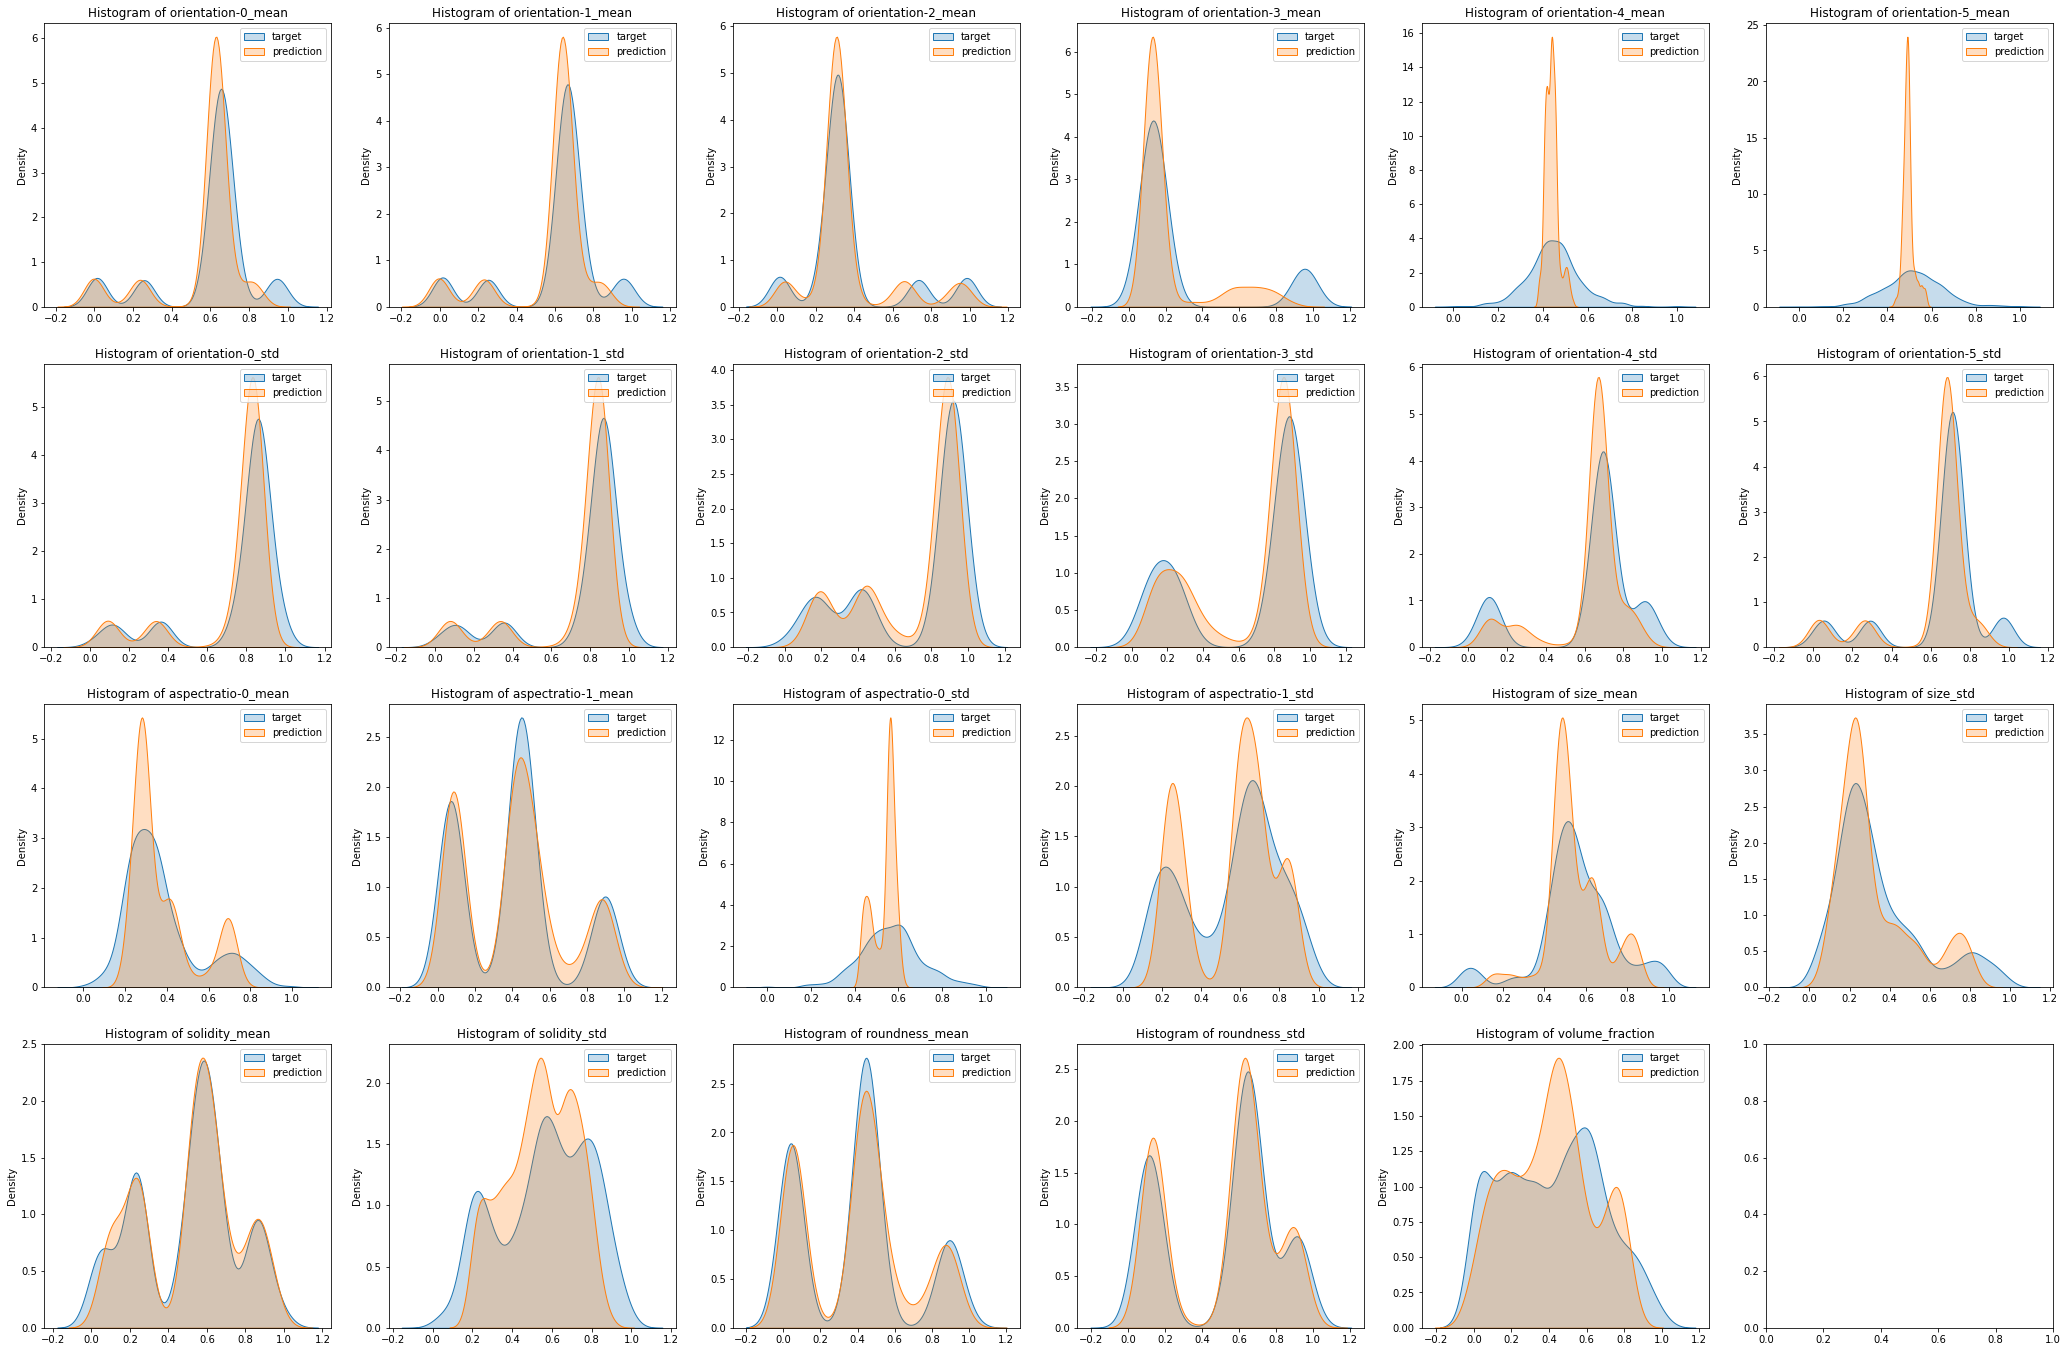

In [11]:
plotting.plot_hist(
    targets.cpu().numpy(),
    predictions.cpu().numpy(),
    nb_hist_per_line=6,
    columns=train_df.columns[1:-1],
)


In [12]:
fabrics_photos_along_x = test_df[
    test_df["photos"].apply(dataframe_reformat.get_path_image_along_axis, args=("x"))
]
fabrics_photos_along_y = test_df[
    test_df["photos"].apply(dataframe_reformat.get_path_image_along_axis, args=("y"))
]
fabrics_photos_along_z = test_df[
    test_df["photos"].apply(dataframe_reformat.get_path_image_along_axis, args=("z"))
]

x_dataset = dataset.SinglePhotoDataset(
    fabrics_photos_along_x, normalization=False, transform=transform
)
y_dataset = dataset.SinglePhotoDataset(
    fabrics_photos_along_y, normalization=False, transform=transform
)
z_dataset = dataset.SinglePhotoDataset(
    fabrics_photos_along_z, normalization=False, transform=transform
)
validation_dataset = dataset.SinglePhotoDataset(
    test_df, normalization=False, transform=transform
)
print(f"Length x set: {len(x_dataset)}")
print(f"Length y set: {len(y_dataset)}")
print(f"Length z set: {len(z_dataset)}")
x_dataloader = DataLoader(
    x_dataset, batch_size=config["batch_size"], shuffle=True, **kwargs
)
y_dataloader = DataLoader(
    y_dataset, batch_size=config["batch_size"], shuffle=True, **kwargs
)
z_dataloader = DataLoader(
    z_dataset, batch_size=config["batch_size"], shuffle=True, **kwargs
)


Length x set: 585
Length y set: 525
Length z set: 511


In [13]:
predictions, targets = training.compute_predictions(model, device, x_dataloader)
errors_x = (
    pd.DataFrame(
        training.compute_errors(predictions, targets, device, scaler),
        columns=train_df.columns[1:-1],
    ).mean()
    * 100
)
predictions, targets = training.compute_predictions(model, device, y_dataloader)
errors_y = (
    pd.DataFrame(
        training.compute_errors(predictions, targets, device, scaler),
        columns=train_df.columns[1:-1],
    ).mean()
    * 100
)
predictions, targets = training.compute_predictions(model, device, z_dataloader)
errors_z = (
    pd.DataFrame(
        training.compute_errors(predictions, targets, device, scaler),
        columns=train_df.columns[1:-1],
    ).mean()
    * 100
)


<AxesSubplot:>

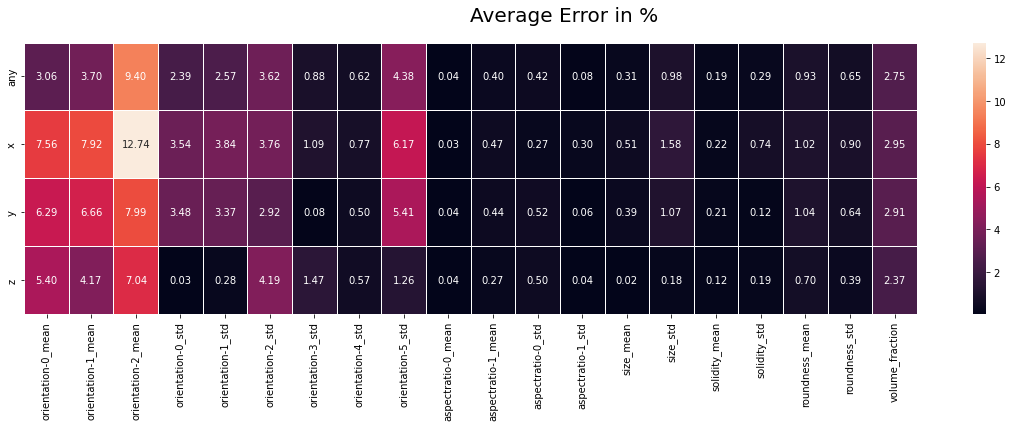

In [19]:
errors_df = pd.DataFrame(
    [errors, errors_x, errors_y, errors_z], index=["any", "x", "y", "z"]
).abs()
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Average Error in %", fontsize=20)
sns.heatmap(
    errors_df.drop(
        labels=["orientation-3_mean", "orientation-4_mean", "orientation-5_mean"],
        axis=1,
    ),
    annot=True,
    linewidths=0.5,
    fmt=".2f",
)


<AxesSubplot:>

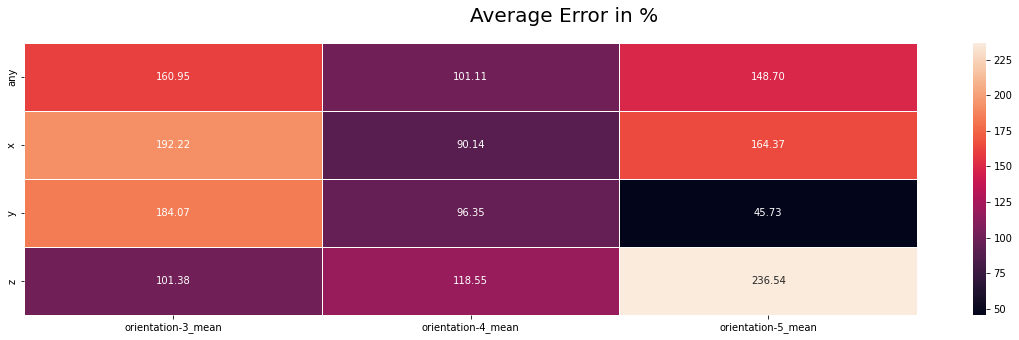

In [20]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Average Error in %", fontsize=20)
sns.heatmap(
    errors_df.loc[
        :, ["orientation-3_mean", "orientation-4_mean", "orientation-5_mean"]
    ],
    annot=True,
    linewidths=0.5,
    fmt=".2f",
)
